In [1]:
def create_images_list(path):
    import os.path
    import glob
    import numpy as np
    from sklearn.cross_validation import train_test_split
    from tensorflow.python.platform import gfile
    
    images_cats = []
    labels_cats = []
    images_dogs = []
    labels_dogs = []
    
    extensions = ['jpg']
    file_list = []
    for extension in extensions:
        file_glob = os.path.join(path,'*.' + extension)
        file_list.extend(glob.glob(file_glob))
        
        if not file_list: continue
            
        for file_name in file_list:
            file_name_with_null = file_name.replace(path+"/","")
            label = file_name_with_null.split(".")[0]
            if label == 'cat':
#                 cats = gfile.FastGFile(file_name, 'rb').read()
                images_cats.append(file_name)
                labels_cats.append(1)
            else:
#                 dogs = gfile.FastGFile(file_name, 'rb').read()
                images_dogs.append(file_name)
                labels_dogs.append(0)
    images = np.hstack((images_cats, images_dogs))
    labels = np.hstack((labels_cats, labels_dogs))
        
    num_images = len(labels)
        
    input_data = np.array([images, labels])
    input_data = input_data.transpose()
    
    np.random.shuffle(input_data)
        
    input_images = input_data[:, 0]
    input_labels = input_data[:, 1]
    input_labels = [int(float(i)) for i in input_labels]
    
#     print("input_labels:", input_labels)
#     print("input_images:", input_images[0])
    
        
    train_images, valid_images, train_labels, valid_labels = train_test_split(
        input_images, input_labels, test_size=0.25, random_state=0)
        
    return train_images, train_labels, valid_images, valid_labels
    
# import matplotlib.pyplot as plt
# TRAIN_DATA_PATH = "C:/Users/yeyiy/Downloads/Dogs vs Cats/maybe"
# train_images, train_labels, valid_images, valid_labels = create_images_list(TRAIN_DATA_PATH)
# print(train_labels) 

In [2]:
def make_batch(images, labels, weight, height, batch_size):
    import numpy as np
    images = tf.cast(images, tf.string)
    labels = tf.cast(labels, tf.int32)
    
    input_data = tf.train.slice_input_producer([images, labels])
    
    image_raw = tf.read_file(input_data[0])
    labels = input_data[1]
    
    # 图像预处理开始
    images = tf.image.decode_jpeg(image_raw, channels=3)
    # 转换图像张量的类型
    images = tf.image.convert_image_dtype(images, dtype=tf.float32)
    # 调整图像为神经网络输入层的大小，调整算法随机
    images = tf.image.resize_images(images, [weight, height],
                                   method=np.random.randint(4))
    # 将图像进行随机左右反转
    images = tf.image.random_flip_left_right(images)
    images = tf.image.per_image_standardization(images)
    # 图像预处理完成
    print("images:", images)
    print("labels:", labels)
    
    min_after_dequeue = 2000
    capacity = min_after_dequeue + 3 * batch_size
    
    image_batch, label_batch = tf.train.batch([images, labels],
                                   batch_size = batch_size,
                                   num_threads = 64,
                                   capacity = capacity)
    
    label_batch = tf.reshape(label_batch, [batch_size])
    return image_batch, label_batch
    

In [3]:
def variable_summaries(var, name):
    with tf.name_scope('summaries'):
        tf.summary.histogram(name, var)
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean/' + name, mean)
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var-mean)))
        tf.summary.scalar('stddev/' + name, stddev)
        

In [10]:
def inference(image_batch, train):
    INPUT_NODE = 268203
    OUTPUT_NODE = 2
    
    IMAGE_SIZE = 299
    NUM_CHANNELS = 3
    NUM_LABELS = 2
    
    CONV1_SIZE = 3
    CONV1_DEEP = 32
    
    CONV2_SIZE = 3
    CONV2_DEEP = 64
    
    FC1_SIZE = 128
    FC2_SIZE = 64
    
    # 第一层卷积层
    with tf.variable_scope("layer1-conv1"):
#         conv1_weights = tf.get_variable(
#             "weight", [CONV1_SIZE, CONV1_SIZE, NUM_CHANNELS, CONV1_DEEP],
#             initializer=tf.truncated_normal_initializer(stddev=0.1))
#          conv1_biases = tf.get_variable(
#             "bias", [CONV1_DEEP], initializer=tf.constant_initalizer(0.0))
        depth = int(list(image_batch.get_shape())[-1])
#         with tf.name_scope('conv1_weights'):
        conv1_weights = tf.Variable(
            tf.truncated_normal([CONV1_SIZE, CONV1_SIZE, depth, CONV1_DEEP], stddev=0.005))
#             variable_summaries(conv1_weights, "layer1-conv1"+'/weights')
            
#         with tf.name_scope('conv1_biases'):
        conv1_biases = tf.Variable(tf.zeros(CONV1_DEEP))
#             variable_summaries(conv1_biases, "layer1-conv1"+'/biases')
        
        # 滤波器边长为5，深度为32，步长2，使用全0填充
        conv1 = tf.nn.conv2d(
            image_batch, conv1_weights, strides=[1,1,1,1], padding="SAME")
        relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_biases))
        
    # 第二层最大池化层, 滤波器边长2，全0填充，步长2
    with tf.name_scope('layer2-pool1'):
        pool1 = tf.nn.max_pool(
            relu1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        
    # 第三层 卷积层
    with tf.name_scope("layer3-conv2"):
#         conv2_weights = tf.get_variable(
#             "weight", [CONV2_SIZE, CONV2_SIZE, CONV1_DEEP, CONV2_DEEP],
#             intializer=tf.truncated.normal_initializer(stddev=0.1))
#         conv2_biases = tf.get_variable(
#             "bias", [CONV2_DEEP], initializer=tf.constant_initializer(0.0))
        conv2_weights = tf.Variable(
            tf.truncated_normal([CONV2_SIZE, CONV2_SIZE, CONV1_DEEP, CONV2_DEEP], stddev=0.005))
        conv2_biases = tf.Variable(tf.zeros(CONV2_DEEP))
        # 滤波器边长为5， 深度64， 步长1， 全0填充
        conv2 = tf.nn.conv2d(
            pool1, conv2_weights, strides=[1,1,1,1], padding="SAME")
        relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_biases))
        
    # 第四层 最大池化层
    with tf.name_scope("layer4-pool2"):
        pool2 = tf.nn.max_pool(
            relu2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
    
    # 扁平化层
    with tf.name_scope("layer5-flatten"):
        flatten = tf.layers.Flatten()(pool2)
        
    # 全连接层
    with tf.name_scope("layer6-fc1"):
        fc1 = tf.contrib.layers.fully_connected(flatten, FC1_SIZE)
        if train: fc1 = tf.nn.dropout(fc1, 0.5)
    
    # 全连接层
    with tf.name_scope("layer7-fc2"):
        fc2 = tf.contrib.layers.fully_connected(fc1, FC2_SIZE)
        
    #输出层
    with tf.name_scope("layer8-output"):
#         depth = list(fc2.get_shape())[1]
#         print(depth)
        output_weights = tf.Variable(tf.truncated_normal([FC2_SIZE, NUM_LABELS], stddev=0.005))
        output_biases = tf.Variable(tf.zeros(NUM_LABELS))
        
        logit = tf.add(tf.matmul(fc2, output_weights), output_biases)
        print("the size of logit:", logit)
    
    return logit

In [11]:
import tensorflow as tf
import numpy as np
import os
TRAIN_PATH = "/home/ubuntu/capson/train"
train_logs_dir = "./logs/train"
valid_logs_dir = "./logs/valid"

N_CLASSES = 2
weight = 299
height = 299
channels = 3
batch_size = 64
Steps = 10000
learning_rate = 0.0001
def training():
    train_images, train_labels, valid_images, valid_labels = \
        create_images_list(TRAIN_PATH)
    train_image_batch, train_label_batch = make_batch(
        train_images, train_labels, weight, height, batch_size)

    valid_image_batch, valid_label_batch = make_batch(
        valid_images, valid_labels, weight, height, batch_size)

    with tf.name_scope('input'):
        x = tf.placeholder(tf.float32, shape=[batch_size, weight, height, channels], name='x')
        y = tf.placeholder(tf.int64, shape=[batch_size], name='y')

    with tf.name_scope('image_raw'):
        image_raw = tf.reshape(x, [64, 299, 299, 3])
        tf.summary.image('input', image_raw, 10)
    
    logits = inference(x, train=True)
    # logits = inference(x)

    print("train_label_batch:", train_label_batch)

    # loss and optimizer
    # loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    #     logits=logits, labels=train_label_batch))
    with tf.variable_scope('loss') as scope:
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits\
                    (logits=logits, labels=y)
        loss = tf.reduce_mean(cross_entropy, name='loss')
        tf.summary.scalar(scope.name+'/loss', loss)
        
    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    #Accuracy
    # correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    # accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    with tf.name_scope('accuracy'):
        with tf.name_scope('coorect_pred'):
            correct_pred = tf.nn.in_top_k(logits, y, 1)
        with tf.name_scope('accuracy'):
            accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
        tf.summary.scalar('accuracy', accuracy)
    
    summary = tf.summary.merge_all()

    with tf.Session() as sess:
        saver = tf.train.Saver()
        sess.run(tf.global_variables_initializer())
    
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
        train_writer = tf.summary.FileWriter(train_logs_dir, sess.graph)
        valid_writer = tf.summary.FileWriter(valid_logs_dir, sess.graph)
    
        try:
            for step in np.arange(Steps):
                if coord.should_stop():
                    break
                train_images, train_labels = sess.run(([train_image_batch, train_label_batch]))
#                 if step ==1:
#                     print("logits:", sess.run(logits, feed_dict={x: train_images}))
#                     print("y_:", train_labels)
                
                _, train_loss, train_acc = sess.run([train_step, loss, accuracy], feed_dict={
                                            x: train_images, y:train_labels})

                if step % 100 == 0:
                    print('Step %d, train loss = %.2f, train accuracy = %.2f%%' %(step, train_loss, train_acc*100.0))
#                     summary_str = sess.run(summary)
#                     train_writer.add_summary(summary_str, step)

                if step % 500 == 0 or (step + 1) == Steps:
                    valid_images, valid_labels = sess.run([valid_image_batch, valid_label_batch])
                    valid_loss, valid_acc = sess.run([loss, accuracy],
                                                     feed_dict={x:valid_images, y:valid_labels})
                    print('**  Step %d, valid loss = %.2f, valid accuracy = %.2f%%  **' %(step, valid_loss, valid_acc*100.0))
#                     summary_str = sess.run(summary)
#                     valid_writer.add_summary(summary_str, step)

                if step % 2000 == 0 or (step + 1) == Steps:
                    checkpoint_path = os.path.join(train_logs_dir, 'model.ckpt')
                    saver.save(sess, checkpoint_path, global_step=step)
            
        except tf.errors.OutOfRangeError:
            print("Done!")
        finally:
            coord.request_stop()
        coord.join(threads)
        
if __name__ == '__main__':
    training()


images: Tensor("per_image_standardization_2:0", shape=(299, 299, 3), dtype=float32)
labels: Tensor("input_producer_2/Gather_1:0", shape=(), dtype=int32)
images: Tensor("per_image_standardization_3:0", shape=(299, 299, 3), dtype=float32)
labels: Tensor("input_producer_3/Gather_1:0", shape=(), dtype=int32)
the size of logit: Tensor("layer8-output_1/Add:0", shape=(64, 2), dtype=float32)
train_label_batch: Tensor("Reshape_2:0", shape=(64,), dtype=int32)
Step 0, train loss = 0.72, train accuracy = 34.38%
**  Step 0, valid loss = 4.28, valid accuracy = 54.69%  **
Step 100, train loss = 0.64, train accuracy = 62.50%
Step 200, train loss = 0.72, train accuracy = 51.56%
Step 300, train loss = 0.62, train accuracy = 70.31%
Step 400, train loss = 0.65, train accuracy = 53.12%
Step 500, train loss = 0.73, train accuracy = 53.12%
**  Step 500, valid loss = 0.62, valid accuracy = 67.19%  **
Step 600, train loss = 0.62, train accuracy = 60.94%
Step 700, train loss = 0.58, train accuracy = 76.56%
Step

In [12]:
#Test one image

TEST_PATH = "/home/ubuntu/capson/test"

def get_one_image(file_dir):
    """
    Randomly pick one image from test data
    Return: ndarray
    """
    from PIL import Image
    import matplotlib.pyplot as plt
    test =[]
    for file in os.listdir(file_dir):
        test.append(file_dir +'/'+ file)
    print('There are %d test pictures\n' %(len(test)))

    n = len(test)
    ind = np.random.randint(0, n)
    print(ind)
    img_test = test[ind]

    image = Image.open(img_test)
    plt.imshow(image)
    image = image.resize([299, 299])
    image = np.array(image)
    return image

def test_one_image():
    """
    Test one image with the saved models and parameters
    """

    test_image = get_one_image(TEST_PATH)

    with tf.Graph().as_default():
        BATCH_SIZE = 1
        N_CLASSES = 2

        image = tf.cast(test_image, tf.float32)
        image = tf.image.per_image_standardization(image)
        image = tf.reshape(image, [1, 299, 299, 3])
        logit = inference(image,train=False)

        logit = tf.nn.softmax(logit)

        x = tf.placeholder(tf.float32, shape=[299, 299, 3])

        saver = tf.train.Saver()

        with tf.Session() as sess:

            print("Reading checkpoints...")
            ckpt = tf.train.get_checkpoint_state(train_logs_dir)
            if ckpt and ckpt.model_checkpoint_path:
                global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
                saver.restore(sess, ckpt.model_checkpoint_path)
                print('Loading success, global_step is %s' % global_step)
            else:
                print('No checkpoint file found')

            prediction = sess.run(logit, feed_dict={x: test_image})
            max_index = np.argmax(prediction)
            if max_index==0:
                print('This is a cat with possibility %.6f' %prediction[:, 0])
            else:
                print('This is a dog with possibility %.6f' %prediction[:, 1])

There are 12500 test pictures

1882
the size of logit: Tensor("layer8-output/Add:0", shape=(1, 2), dtype=float32)
Reading checkpoints...
INFO:tensorflow:Restoring parameters from ./logs/train/model.ckpt-9999


InvalidArgumentError: Assign requires shapes of both tensors to match. lhs shape= [16] rhs shape= [32]
	 [[Node: save/Assign_5 = Assign[T=DT_FLOAT, _class=["loc:@layer1-conv1/Variable_1"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](layer1-conv1/Variable_1, save/RestoreV2/_17)]]
	 [[Node: save/RestoreV2/_8 = _Send[T=DT_FLOAT, client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_13_save/RestoreV2", _device="/job:localhost/replica:0/task:0/device:CPU:0"](save/RestoreV2)]]

Caused by op 'save/Assign_5', defined at:
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/base_events.py", line 1431, in _run_once
    handle._run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-03870065ec48>", line 2, in <module>
    test_one_image()
  File "<ipython-input-12-40e769d0e933>", line 48, in test_one_image
    saver = tf.train.Saver()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1311, in __init__
    self.build()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1320, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1357, in _build
    build_save=build_save, build_restore=build_restore)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 809, in _build_internal
    restore_sequentially, reshape)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 470, in _AddRestoreOps
    assign_ops.append(saveable.restore(saveable_tensors, shapes))
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 162, in restore
    self.op.get_shape().is_fully_defined())
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 281, in assign
    validate_shape=validate_shape)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 61, in assign
    use_locking=use_locking, name=name)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Assign requires shapes of both tensors to match. lhs shape= [16] rhs shape= [32]
	 [[Node: save/Assign_5 = Assign[T=DT_FLOAT, _class=["loc:@layer1-conv1/Variable_1"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](layer1-conv1/Variable_1, save/RestoreV2/_17)]]
	 [[Node: save/RestoreV2/_8 = _Send[T=DT_FLOAT, client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_13_save/RestoreV2", _device="/job:localhost/replica:0/task:0/device:CPU:0"](save/RestoreV2)]]


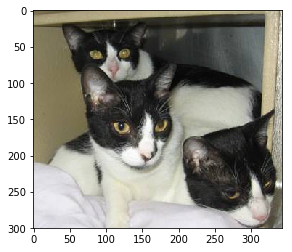

In [13]:
if __name__ == '__main__':
    test_one_image()